In [1]:
import torch
from torch import Tensor
import torch.nn as nn
import torchvision
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import numpy as np 
from torch.utils.data import Dataset, DataLoader
import os 
from torchmetrics.classification.accuracy import BinaryAccuracy

import os 
import pandas as pd 

from torchvision.io import read_image, ImageReadMode
import torchvision.transforms as T
import pickle 

In [2]:
# Will display a corresponding image and bounding boxes / predictions made for it 
from torchvision.utils import draw_bounding_boxes
import torchvision.transforms.functional as F


def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])



In [3]:
TRAIN_SEGMENTATION = "SegmentationMaps/train"
VAL_SEGMENTATION = "SegmentationMaps/val"
TEST_SEGMENTATION = "SegmentationMaps/test"

In [4]:
seg_df = pd.read_csv(f"{TRAIN_SEGMENTATION}/_classes.csv")
seg_df.head() 

pixel_maps = {} 
for i in seg_df.T:
    row = seg_df.loc[i] 
    val = row['Pixel Value'] 
    cl = row[' Class'] 
    pixel_maps[cl] = val 
print(pixel_maps)     

{' background': 0, ' Road': 1}


In [5]:
class SegDL(Dataset):
    def __init__(self, lof_mappings):
        self.lof_mappings = lof_mappings 
    def __len__(self):
        return len(self.lof_mappings) 
    
    def __getitem__(self, idx):
        pair = self.lof_mappings[idx] 
        return pair 


resize_factor = T.Resize((128,128), antialias=True)
def clean_image(img):    
    img = resize_factor.forward(img)     
    img = img.float() 
    img = img.unsqueeze(0) 
    return img 
    
def create_segmentation_dl_obj(PATH):
    lof_images = [] 
    for file in os.listdir(TRAIN_SEGMENTATION):
        if '.csv' not in file and '_mask' not in file:
            mask_file = file.replace(".jpg", "") 
            mask_file = f"{mask_file}_mask.png" 
        
            img = read_image(f"{TRAIN_SEGMENTATION}/{file}",ImageReadMode.RGB )
            img = clean_image(img) 
            
            m_img = read_image(f"{TRAIN_SEGMENTATION}/{mask_file}")
            m_img = clean_image(m_img) 
            
            lof_images.append((img, m_img))
            break 
    return SegDL(lof_images)  
seg_training_dl = create_segmentation_dl_obj(TRAIN_SEGMENTATION)
seg_val_dl = create_segmentation_dl_obj(VAL_SEGMENTATION)
seg_test_dl = create_segmentation_dl_obj(TEST_SEGMENTATION)

In [6]:

class MarioSegmentation(pl.LightningModule):
    
    def __init__(self):
        super().__init__()

        self.acc_metric = BinaryAccuracy()
        self.criterion = nn.BCELoss()
        
        self.first_downsample = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=2, padding=1),  
            nn.BatchNorm2d(32), 
            nn.ReLU(True) , 
        )

        self.second_downsample = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1),  
            nn.BatchNorm2d(64), 
            nn.ReLU(True)  
        )

        self.third_downsample = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1),  
            nn.BatchNorm2d(128), 
            nn.ReLU(True) , 
        )


        self.first_upsample = nn.Sequential(
          nn.ConvTranspose2d(in_channels=128, out_channels=64,  kernel_size=3, stride=2, padding=1, output_padding=1), 
          nn.BatchNorm2d(64), 
          nn.ReLU(True) , 
        )

        self.second_upsample = nn.Sequential(
          nn.ConvTranspose2d(in_channels=64, out_channels=32,  kernel_size=3, stride=2, padding=1, output_padding=1), 
          nn.BatchNorm2d(32), 
          nn.ReLU(True) , 
        )

        self.third_upsample =  nn.Sequential( 
          nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, stride=2, padding=1, output_padding=1), 
          nn.BatchNorm2d(16), 
          nn.ReLU(True) , 
        )
        self.final_layer = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=1, kernel_size=1),  
        )
         
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer 
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        y[y==255] = 0
        y[y>0] = 1
        y_pred = self.forward(x) 
        loss = self.criterion(y_pred, y.float())
        self.log("train_loss", loss)
        acc = self.acc_metric(y_pred, y)
        self.log("train_acc", acc, prog_bar=True)
        return loss     
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y[y==255] = 0
        y[y>0] = 1
        y_pred = self.forward(x) 
        loss = self.criterion(y_pred, y.float())
        self.log("train_loss", loss)
        acc = self.acc_metric(y_pred, y)
        self.log("train_acc", acc, prog_bar=True)
        return loss
 
    def forward(self, x):
        first_downsample = self.first_downsample(x) 
        second_downsample = self.second_downsample(first_downsample) 

        third_downsample = self.third_downsample(second_downsample) 


        first_upsample = self.first_upsample(third_downsample)

        merge = first_upsample  + second_downsample 

        second_upsample = self.second_upsample(merge) 

        merge = second_upsample + first_downsample 
        third_upsample = self.third_upsample(merge) 
        result = self.final_layer(third_upsample) 

        return nn.Sigmoid()(result)   


# Creating dataloader objects for these! 
model = MarioSegmentation() 

In [7]:
trainer = pl.Trainer(max_epochs=100,
                     logger=pl.loggers.TensorBoardLogger('./voc'),
                     log_every_n_steps=1) 
trainer.fit(model=model, train_dataloaders=seg_training_dl, val_dataloaders=seg_val_dl) 


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name              | Type           | Params
-----------------------------------------------------
0 | acc_metric        | BinaryAccuracy | 0     
1 | criterion         | BCELoss        | 0     
2 | first_downsample  | Sequential     | 960   
3 | second_downsample | Sequential     | 18.6 K
4 | third_downsample  | Sequential     | 74.1 K
5 | first_upsample    | Sequential     | 73.9 K
6 | second_upsample   | Sequential     | 18.5 K
7 | third_upsample    | Sequential     | 4.7 K 
8 | final_layer       | Sequential     | 17    
-----------------------------------------------------
190 K     Trainable params
0         Non-trainable params
190 K     Total params
0.763     Total estimated model params size (MB)


Epoch 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.78it/s, v_num=70, train_acc=0.580]
Validation: 0it [00:00, ?it/s]
Epoch 1: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.20it/s, v_num=70, train_acc=0.734]
Validation: 0it [00:00, ?it/s]
Epoch 2: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.89it/s, v_num=70, train_acc=0.780]
Validation: 0it [00:00, ?it/s]
Epoch 3: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.37it/s, v_num=70, train_acc=0.823]
Validation: 0it [00:00, ?it/s]
Epoch 4: 100%|██████████████████████████████████████████████████

Epoch 10: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.33it/s, v_num=70, train_acc=0.950]
Validation: 0it [00:00, ?it/s]
Epoch 11: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 33.14it/s, v_num=70, train_acc=0.957]
Validation: 0it [00:00, ?it/s]
Epoch 12: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.85it/s, v_num=70, train_acc=0.964]
Validation: 0it [00:00, ?it/s]
Epoch 13: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.67it/s, v_num=70, train_acc=0.974]
Validation: 0it [00:00, ?it/s]
Epoch 14: 100%|█████████████████████████████████████████████████

Epoch 19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30.03it/s, v_num=70, train_acc=0.990]
Validation: 0it [00:00, ?it/s]
Epoch 20: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.64it/s, v_num=70, train_acc=0.990]
Validation: 0it [00:00, ?it/s]
Epoch 21: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30.81it/s, v_num=70, train_acc=0.991]
Validation: 0it [00:00, ?it/s]
Epoch 22: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32.30it/s, v_num=70, train_acc=0.992]
Validation: 0it [00:00, ?it/s]
Epoch 23: 100%|█████████████████████████████████████████████████

Epoch 29: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30.73it/s, v_num=70, train_acc=0.994]
Validation: 0it [00:00, ?it/s]
Epoch 30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 34.27it/s, v_num=70, train_acc=0.995]
Validation: 0it [00:00, ?it/s]
Epoch 31: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.81it/s, v_num=70, train_acc=0.995]
Validation: 0it [00:00, ?it/s]
Epoch 32: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 34.58it/s, v_num=70, train_acc=0.995]
Validation: 0it [00:00, ?it/s]
Epoch 33: 100%|█████████████████████████████████████████████████

Epoch 38: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.62it/s, v_num=70, train_acc=0.996]
Validation: 0it [00:00, ?it/s]
Epoch 39: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28.04it/s, v_num=70, train_acc=0.996]
Validation: 0it [00:00, ?it/s]
Epoch 40: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.70it/s, v_num=70, train_acc=0.996]
Validation: 0it [00:00, ?it/s]
Epoch 41: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.88it/s, v_num=70, train_acc=0.996]
Validation: 0it [00:00, ?it/s]
Epoch 42: 100%|█████████████████████████████████████████████████

Epoch 48: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.48it/s, v_num=70, train_acc=0.998]
Validation: 0it [00:00, ?it/s]
Epoch 49: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.37it/s, v_num=70, train_acc=0.998]
Validation: 0it [00:00, ?it/s]
Epoch 50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.88it/s, v_num=70, train_acc=0.998]
Validation: 0it [00:00, ?it/s]
Epoch 51: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.80it/s, v_num=70, train_acc=0.998]
Validation: 0it [00:00, ?it/s]
Epoch 52: 100%|█████████████████████████████████████████████████

Epoch 57: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.97it/s, v_num=70, train_acc=0.999]
Validation: 0it [00:00, ?it/s]
Epoch 58: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.32it/s, v_num=70, train_acc=0.999]
Validation: 0it [00:00, ?it/s]
Epoch 59: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.98it/s, v_num=70, train_acc=0.999]
Validation: 0it [00:00, ?it/s]
Epoch 60: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.15it/s, v_num=70, train_acc=0.999]
Validation: 0it [00:00, ?it/s]
Epoch 61: 100%|█████████████████████████████████████████████████

Epoch 67: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.31it/s, v_num=70, train_acc=0.999]
Validation: 0it [00:00, ?it/s]
Epoch 68: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.36it/s, v_num=70, train_acc=0.999]
Validation: 0it [00:00, ?it/s]
Epoch 69: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.55it/s, v_num=70, train_acc=0.999]
Validation: 0it [00:00, ?it/s]
Epoch 70: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28.33it/s, v_num=70, train_acc=0.999]
Validation: 0it [00:00, ?it/s]
Epoch 71: 100%|█████████████████████████████████████████████████

Epoch 76: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29.07it/s, v_num=70, train_acc=1.000]
Validation: 0it [00:00, ?it/s]
Epoch 77: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.61it/s, v_num=70, train_acc=1.000]
Validation: 0it [00:00, ?it/s]
Epoch 78: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.66it/s, v_num=70, train_acc=1.000]
Validation: 0it [00:00, ?it/s]
Epoch 79: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.82it/s, v_num=70, train_acc=1.000]
Validation: 0it [00:00, ?it/s]
Epoch 80: 100%|█████████████████████████████████████████████████

Epoch 86: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28.09it/s, v_num=70, train_acc=1.000]
Validation: 0it [00:00, ?it/s]
Epoch 87: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.68it/s, v_num=70, train_acc=1.000]
Validation: 0it [00:00, ?it/s]
Epoch 88: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.78it/s, v_num=70, train_acc=1.000]
Validation: 0it [00:00, ?it/s]
Epoch 89: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28.15it/s, v_num=70, train_acc=1.000]
Validation: 0it [00:00, ?it/s]
Epoch 90: 100%|█████████████████████████████████████████████████

Epoch 95: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.03it/s, v_num=70, train_acc=1.000]
Validation: 0it [00:00, ?it/s]
Epoch 96: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.83it/s, v_num=70, train_acc=1.000]
Validation: 0it [00:00, ?it/s]
Epoch 97: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.49it/s, v_num=70, train_acc=1.000]
Validation: 0it [00:00, ?it/s]
Epoch 98: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.44it/s, v_num=70, train_acc=1.000]
Validation: 0it [00:00, ?it/s]
Epoch 99: 100%|█████████████████████████████████████████████████

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.27it/s, v_num=70, train_acc=1.000]


In [8]:
if True:
    print("Saving model to pickle")
    torch.save(model.state_dict(), "segmentation_model_weights") 


Saving model to pickle


In [9]:
def test_process_image(img_path):
    img = read_image(f"{img_path}", ImageReadMode.RGB)

        size = T.functional.get_image_size(img)
        width, height = size
        img = self.resize_obj.forward(img)

        img = img.float()
        img = img.unsqueeze(0)

        return img

IndentationError: unexpected indent (2988536710.py, line 4)

In [ ]:
idx = 20
test_images = [] 
for file in os.listdir("Images/"):
    test_images.append(file) 

for idx in range(1, 10):
#     idx = 38

    # for idx in range(len(test_images)):
    img = read_image(f"Images/{test_images[idx]}", ImageReadMode.RGB)
    show(img) 
    img = clean_image(img) 

    out = model.forward(img)

    out = out.float()
    out = out.squeeze(0)
    
    out = out > 0.7
    out = out.float() 

    show(out) 




torch.Size([1, 1, 128, 128])
torch.Size([1, 1, 128, 128])


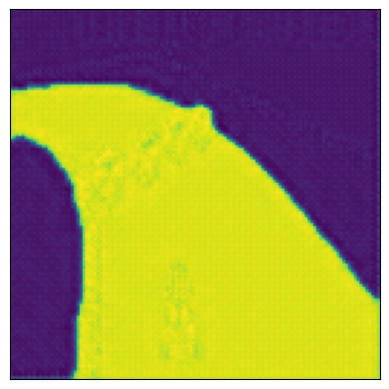

In [11]:
test_image = seg_training_dl[0][0]

out = model.forward(test_image) 
print(out.shape) 
print(out.shape) 
out = out.squeeze(0)

show(out) 

In [12]:
pred_images = [] 

for batch in seg_test_dl:
    img = batch[0]
    # 1 if it is predicted to be > .5 for the road, otherwise 0 
    preds = model.forward(img).squeeze(0) 
    preds = preds > .5 
    preds = preds.float() 
    pred_images.append(preds)


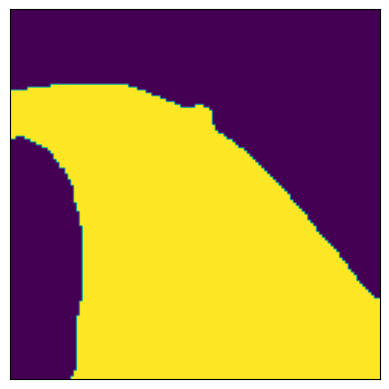

In [13]:
test = pred_images[0]
show(test) 

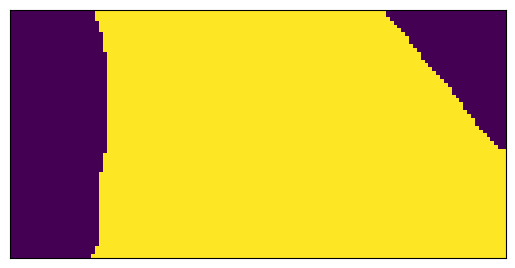

In [14]:
# Divide horizontally 
top_half = torch.hsplit(test, 2)[1]

show(top_half) 

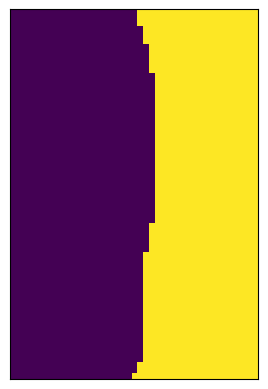

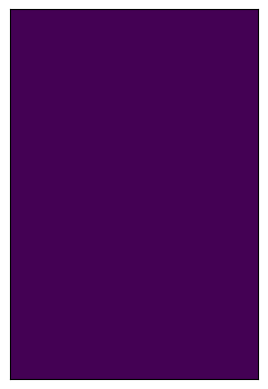

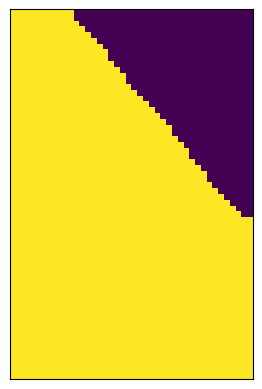

In [15]:
thirds = torch.tensor_split(top_half, 3, dim=2)
for t in thirds:
    show(t) 

In [16]:

# Divided area into three sections, where each section corresponds to a location we can move to 
directions = {'a':thirds[0], 'w':thirds[1],'d':thirds[2]} 

optimal_direct = None
optimal_score = None 
totalSum = 0 

for key in directions:
    key_score = torch.sum(directions[key])
    totalSum += key_score
    if optimal_direct is None or optimal_score < key_score:
        optimal_direct = key
        optimal_score = key_score
print((optimal_score / totalSum - 0.6) * 10) 
print(f"We should press the {optimal_direct} key!")

#tensor(0.6753)
#0.6141
#0.6230

tensor(-1.4580)
We should press the w key!


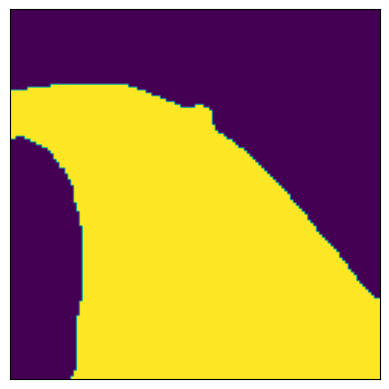

In [26]:
test = pred_images[0] 
show(test)

In [18]:
# Assume player in middle, calculate middle point some degree ahead? 

In [50]:
import cv2 
# test = np.array(test) 
test = pred_images[0] 
test = F.to_pil_image(test)
test = np.array(test) 

In [51]:
test = cv2.ximgproc.thinning(test) 

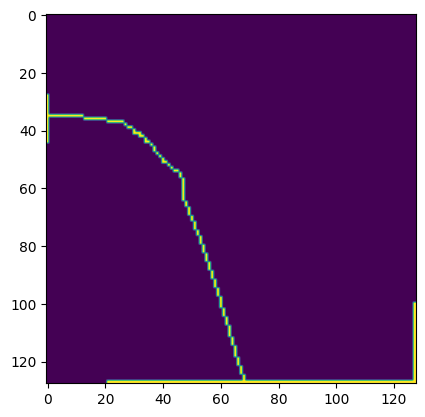

In [45]:
from matplotlib import pyplot as plt

plt.imshow(test) 

In [52]:
# cv2.HoughLines(test,1, np.pi/180, 1) 
print(test) 

[[  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 ...
 [  0   0   0 ...   0   0 255]
 [  0   0   0 ...   0   0 255]
 [  0   0   0 ... 255 255 255]]


In [53]:
cv2.fitLine(test, cv2.DIST_L2, 0, 0.01, 0.01)

error: OpenCV(4.7.0) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/linefit.cpp:618: error: (-215:Assertion failed) npoints2 >= 0 || npoints3 >= 0 in function 'fitLine'


In [55]:
points = cv2.findNonZero(test) 
vals = cv2.fitLine(points, cv2.DIST_L2, 0, 0.01, 0.01) 


array([[ 0.7203659],
       [ 0.6935943],
       [60.978024 ],
       [94.47619  ]], dtype=float32)